In [1]:
cd C:\\Users\\Sharuka Thirimanne\\Desktop\\FYP-ML-IDS

C:\Users\Sharuka Thirimanne\Desktop\FYP-ML-IDS


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [3]:
def load_train_dataset():
    df_train = pd.read_csv('USNW_train-set1.csv')
    df_train = shuffle(df_train)
    df_train['label'].replace({1 : -1, 0 : 1}, inplace = True)

    normal = df_train.loc[df_train['label'] == 1]
    anomaly = df_train.loc[df_train['label'] == -1]
    
    lim = df_train.shape[1]-1
    limit = normal.shape[1]-1
    
    X_train = df_train.iloc[:,0:lim]
    Y_train = df_train.iloc[:,lim]
    
    X_normal = normal.iloc[:,0:limit]
    Y_normal = normal.iloc[:,limit]
    
    X_train.reset_index(inplace=True, drop=True)
    Y_train.reset_index(inplace=True, drop=True)
    X_normal.reset_index(inplace=True, drop=True)
    Y_normal.reset_index(inplace=True, drop=True)
    
    return X_train, Y_train, X_normal, Y_normal, normal, anomaly

X_train, Y_train, X_normal, Y_normal, normal, anomaly = load_train_dataset()

In [4]:
def load_test_dataset():
    df_test = pd.read_csv('USNW_test-set1.csv')
    df_test = shuffle(df_test)
    df_test['label'].replace({1 : -1, 0 : 1}, inplace = True)

    limit = df_test.shape[1]-1
    
    X_test = df_test.iloc[:,0:limit]
    Y_test = df_test.iloc[:,limit]
    
    X_test.reset_index(inplace=True, drop=True)
    Y_test.reset_index(inplace=True, drop=True)
    
    return X_test, Y_test, df_test

X_test, Y_test, df_test = load_test_dataset()

In [5]:
categorical_cols = ['proto','service','state']

col_trans = ColumnTransformer([('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)], remainder='passthrough')

In [6]:
oneclass_classifier = OneClassSVM(gamma=0.15,nu=0.5)

In [7]:
pipe = Pipeline([
    ('col_trans',col_trans),
    ('scale',StandardScaler()),
    ('svm_model',oneclass_classifier),])

In [8]:
pipe.fit(X_normal)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['proto', 'service',
                                                   'state'])])),
                ('scale', StandardScaler()),
                ('svm_model', OneClassSVM(gamma=0.15))])

In [ ]:
param_grid = {'svm_model__gamma' : np.arange(0.1,0.5,0.05).tolist(),
              'svm_model__nu' : np.arange(0.1,0.5,0.05).tolist()}

optimal_params = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv=5,
    scoring ='accuracy',
    verbose = 2
)

optimal_params.fit(X_test,Y_test)
print(optimal_params.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] svm_model__gamma=0.1, svm_model__nu=0.1 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... svm_model__gamma=0.1, svm_model__nu=0.1, total= 1.7min
[CV] svm_model__gamma=0.1, svm_model__nu=0.1 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] .......... svm_model__gamma=0.1, svm_model__nu=0.1, total= 1.7min
[CV] svm_model__gamma=0.1, svm_model__nu=0.1 .........................
[CV] .......... svm_model__gamma=0.1, svm_model__nu=0.1, total= 1.6min
[CV] svm_model__gamma=0.1, svm_model__nu=0.1 .........................
[CV] .......... svm_model__gamma=0.1, svm_model__nu=0.1, total= 1.7min
[CV] svm_model__gamma=0.1, svm_model__nu=0.1 .........................
[CV] .......... svm_model__gamma=0.1, svm_model__nu=0.1, total= 1.8min
[CV] svm_model__gamma=0.1, svm_model__nu=0.15000000000000002 .........
[CV]  svm_model__gamma=0.1, svm_model__nu=0.15000000000000002, total= 2.6min
[CV] svm_model__gamma=0.1, svm_model__nu=0.15000000000000002 .........
[CV]  svm_model__gamma=0.1, svm_model__nu=0.15000000000000002, total= 2.4min
[CV] svm_model__gamma=0.1, svm_model__nu=0.15000000000000002 .........
[CV]  svm_model__gamma=0.1, svm_model__nu=0.15000000000000002, total= 2.3min
[CV] svm_model__gamma=0.1, svm_model__nu=0.1500000000000000

In [9]:
predictions = pipe.predict(X_test)

In [10]:
predictions

array([-1,  1, -1, ...,  1,  1, -1], dtype=int64)

True Negatives  : 0.94
False Positives : 0.06
False Negatives : 0.59
True Positives  : 0.41


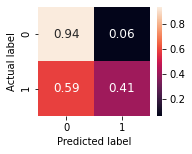

In [11]:
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions, normalize= 'true')
    plt.figure(figsize=(2.5,2))
    sns.heatmap(cm, annot=True, fmt=".2f",annot_kws={'size':12})
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives  : {:.2f}'.format(cm[0][0]))
    print('False Positives : {:.2f}'.format(cm[0][1]))
    print('False Negatives : {:.2f}'.format(cm[1][0]))
    print('True Positives  : {:.2f}'.format(cm[1][1]))
    
plot_cm(Y_test,predictions)

In [12]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

          -1       0.48      0.94      0.63     19695
           1       0.92      0.41      0.57     34204

    accuracy                           0.60     53899
   macro avg       0.70      0.67      0.60     53899
weighted avg       0.76      0.60      0.59     53899



In [13]:

#print("Train set accuracy           : {:.4f}".format(oneclass_classifier.score_samples(X_train)))
print("Test set accuracy            : {:.4f}".format(accuracy_score(Y_test, predictions)))

Test set accuracy            : 0.6019


In [14]:
print("Test set precision : {:.4f}".format(precision_score(Y_test, predictions)))
print("Test set recall    : {:.4f}".format(recall_score(Y_test, predictions)))
print("Test set F1-score  : {:.4f}".format(f1_score(Y_test, predictions)))

Test set precision : 0.9188
Test set recall    : 0.4088
Test set F1-score  : 0.5658


c:\users\sharuka thirimanne\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


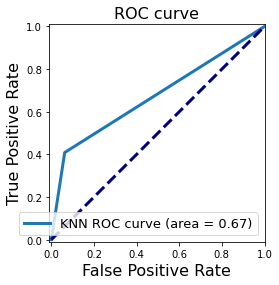

In [15]:
fpr_lr, tpr_lr, _ = roc_curve(Y_test, predictions)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='KNN ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()